In [167]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import cv2

### Task 1

In [161]:
class KDE:
    def __init__(self, kernel='gaussian'):
        self.kernel = kernel
        self.data = None
        self.bandwidth = None

    def fit(self, data):
        self.data = np.asarray(data)
        self._select_bandwidth()

    def _gaussian_kernel(self, x):
        return np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi)

    def _box_kernel(self, x):
        return 0.5 * (np.abs(x) <= 1)

    def _triangular_kernel(self, x):
        return np.maximum(1 - np.abs(x), 0)

    def _select_bandwidth(self):
        bandwidths = 10 ** np.linspace(-1, 1, 50)
        log_likelihoods = np.zeros_like(bandwidths)

        for i, bandwidth in enumerate(bandwidths):
            log_likelihood = 0
            for j in range(len(self.data)):
                data_point = np.array([self.data[j]])
                data_without_point = np.delete(self.data, j, axis=0)
                conditional_density = self.evaluate_density(data_point, bandwidth)
                log_likelihood += np.log(conditional_density)
            log_likelihoods[i] = log_likelihood
        self.bandwidth = bandwidths[np.argmax(log_likelihoods)]

    def evaluate_density(self, x, bandwidth=None):
        if self.data is None:
            raise ValueError("Fit data first before evaluating density.")
        if bandwidth is None:
            bandwidth = self.bandwidth

        if self.kernel == 'gaussian':
            kernel_func = self._gaussian_kernel
        elif self.kernel == 'box':
            kernel_func = self._box_kernel
        elif self.kernel == 'triangular':
            kernel_func = self._triangular_kernel
        else:
            raise ValueError("Invalid kernel type.")

        density = np.zeros_like(x)
        for i, val in enumerate(x):
            kernel_val = kernel_func((val - self.data) / bandwidth)
            density[i] = np.sum(kernel_val) / (bandwidth * len(self.data))

        return density

    def visualize_pdf(self, num_points=100):
        if self.data is None:
            raise ValueError("Fit data first before visualizing.")
        if self.data.shape[1] > 2:
            raise ValueError("Visualization is supported for 1-D and 2-D data only.")

        if self.data.shape[1] == 1:
            x_range = np.linspace(np.min(self.data), np.max(self.data), num_points)
            pdf_values = [self.evaluate_density(np.array([x])) for x in x_range]

            plt.plot(x_range, pdf_values, label="KDE")
            plt.hist(self.data, bins='auto', density=True, alpha=0.5, label="Data")
            plt.legend()
            plt.title("Kernel Density Estimation (1-D)")
            plt.show()
        else:
            plt.scatter(self.data[:, 0], self.data[:, 1], alpha=0.5, label="Data")
            plt.title("Kernel Density Estimation (2-D)")
            plt.legend()
            plt.show()


In [162]:
data_sample = np.random.rand(2500, 1) * 2 - 1

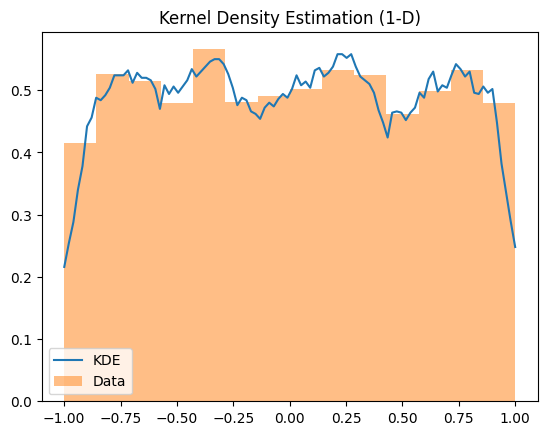

In [163]:
box = KDE(kernel='box')
box.fit(data_sample)
box.visualize_pdf()



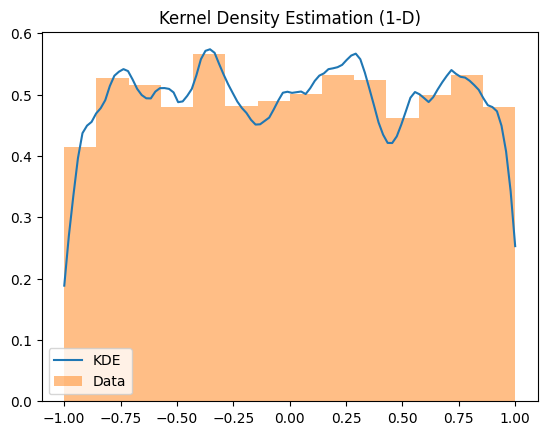

In [164]:
tri = KDE(kernel='triangular')
tri.fit(data_sample)
tri.visualize_pdf()


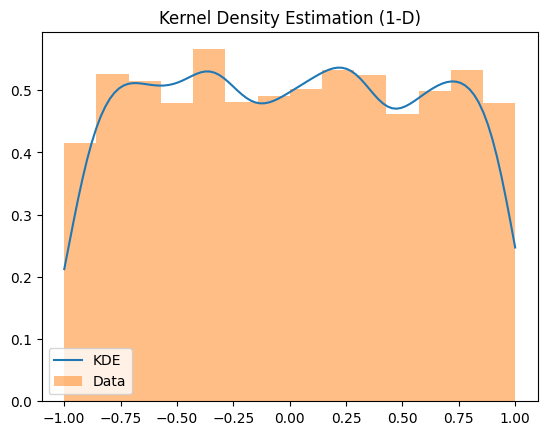

In [165]:
gau = KDE(kernel='gaussian')
gau.fit(data_sample)
gau.visualize_pdf()


### Task 2

In [185]:
data_csv = ["./data/TLBR_29.csv", "./data/TLBR_101.csv", "./data/TLBR_159.csv", "./data/TLBR_174.csv"]
data_img = ["./images/29.jpg", "./images/101.jpg", "./images/159.jpg", "./images/174.jpg"]

In [168]:
def visualize_bboxes(img, df):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    # print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)
  plt.imshow(img_2)

In [179]:
def make_connections(image, euclidean):

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      left_adjacent_id = int(row['Left_box'][1])
      right_adjacent_id = int(row['Right_box'][1])
      top_adjacent_id = int(row['Top_box'][1])
      bottom_adjacent_id = int(row['Bottom_box'][1])

      line_color = (0, 0, 0)  # Black
      # line_color = (255, 0, 0)  # Blue

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), line_color, 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), line_color, 2)

      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, line_color, 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), line_color, 2)

  return image_with_boxes


In [174]:
def calculate_boxes(df, data, vertical_threshold, horizontal_threshold):
    for ind, row in df.iterrows():
        min_dist = 1e9
        box_Id = -1
        for ind2, row2 in df.iterrows():
            # data['Center'][ind][0] > data['Center'][ind2][0] means the box2 is left to the current box1
            if(ind != ind2 and data['Center'][ind][0] > data['Center'][ind2][0]):
                distX = abs(data['Center'][ind][0] - data['Center'][ind2][0])
                distY = abs(data['Center'][ind][1] - data['Center'][ind2][1])
                if(distX < min_dist and distX <= horizontal_threshold and distY <= vertical_threshold):
                    min_dist = distX
                    box_Id = row2['Id']
        if(box_Id != -1):
            data['Left_box'].append([min_dist, box_Id])
        else:
            data['Left_box'].append([-1, 0])  # to remove connection

    for ind, row in df.iterrows():
        min_dist = 1e9
        box_Id = -1
        for ind2, row2 in df.iterrows():
            # data['Center'][ind][0] < data['Center'][ind2][0] means the box2 is right to the current box1
            if(ind != ind2 and data['Center'][ind][0] < data['Center'][ind2][0]):
                distX = abs(data['Center'][ind][0] - data['Center'][ind2][0])
                distY = abs(data['Center'][ind][1] - data['Center'][ind2][1])
                if(distX < min_dist and distX <= horizontal_threshold and distY <= vertical_threshold):
                    min_dist = distX
                    box_Id = row2['Id']
        if(box_Id != -1):
            data['Right_box'].append([min_dist, box_Id])
        else:
            data['Right_box'].append([-1, 0])  # to remove connection

    for ind, row in df.iterrows():
        min_dist = 1e9
        box_Id = -1
        for ind2, row2 in df.iterrows():
            # data['Center'][ind][1] > data['Center'][ind2][1] means the box2 is below the current box1
            if(ind != ind2 and data['Center'][ind][1] > data['Center'][ind2][1]):
                distX = abs(data['Center'][ind][0] - data['Center'][ind2][0])
                distY = abs(data['Center'][ind][1] - data['Center'][ind2][1])
                if(distY < min_dist and distY <= vertical_threshold and distX <= horizontal_threshold):
                    min_dist = distY
                    box_Id = row2['Id']
        if(box_Id != -1):
            data['Bottom_box'].append([min_dist, box_Id])
        else:
            data['Bottom_box'].append([-1, 0])  # to remove connection

    for ind, row in df.iterrows():
        min_dist = 1e9
        box_Id = -1
        for ind2, row2 in df.iterrows():
            # data['Center'][ind][1] < data['Center'][ind2][1] means the box2 is above the current box1
            if(ind != ind2 and data['Center'][ind][1] < data['Center'][ind2][1]):
                distX = abs(data['Center'][ind][0] - data['Center'][ind2][0])
                distY = abs(data['Center'][ind][1] - data['Center'][ind2][1])
                if(distY < min_dist and distY <= vertical_threshold and distX <= horizontal_threshold):
                    min_dist = distY
                    box_Id = row2['Id']
        if(box_Id != -1):
            data['Top_box'].append([min_dist, box_Id])
        else:
            data['Top_box'].append([-1, 0]) # to remove connection
    return data

In [177]:
def make_data(df):
    columns = ['Id', 'Top-Left', 'Bottom-Right', 'Top', 'Left', 'Bottom', 'Right', 'Top_box', 'Bottom_box', 'Left_box', 'Right_box', 'Center']
    data = {column: [] for column in columns}

    for index, rows in df.iterrows():
        top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
        bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
        top = [(top_left[0] + bottom_right[0])/2, top_left[1]]
        left = [top_left[0], (top_left[1] + bottom_right[1])/2]
        bottom = [(top_left[0] + bottom_right[0])/2, bottom_right[1]]
        right = [bottom_right[0], (top_left[1] + bottom_right[1])/2]
        center = ((top_left[0] + bottom_right[0])/2, (top_left[1] + bottom_right[1])/2)

        data['Id'].append(rows['Id'])
        data['Top-Left'].append(top_left)
        data['Bottom-Right'].append(bottom_right)
        data['Top'].append(top)
        data['Left'].append(left)
        data['Bottom'].append(bottom)
        data['Right'].append(right)
        data['Center'].append(center)

    return data

Image:  ./images/29.jpg


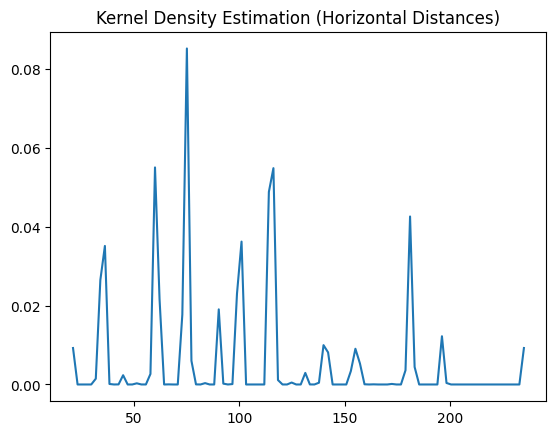

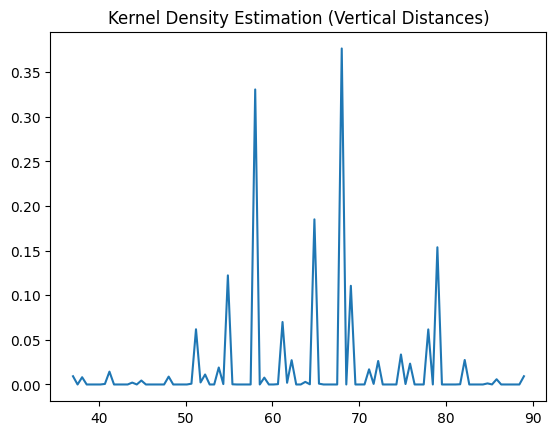

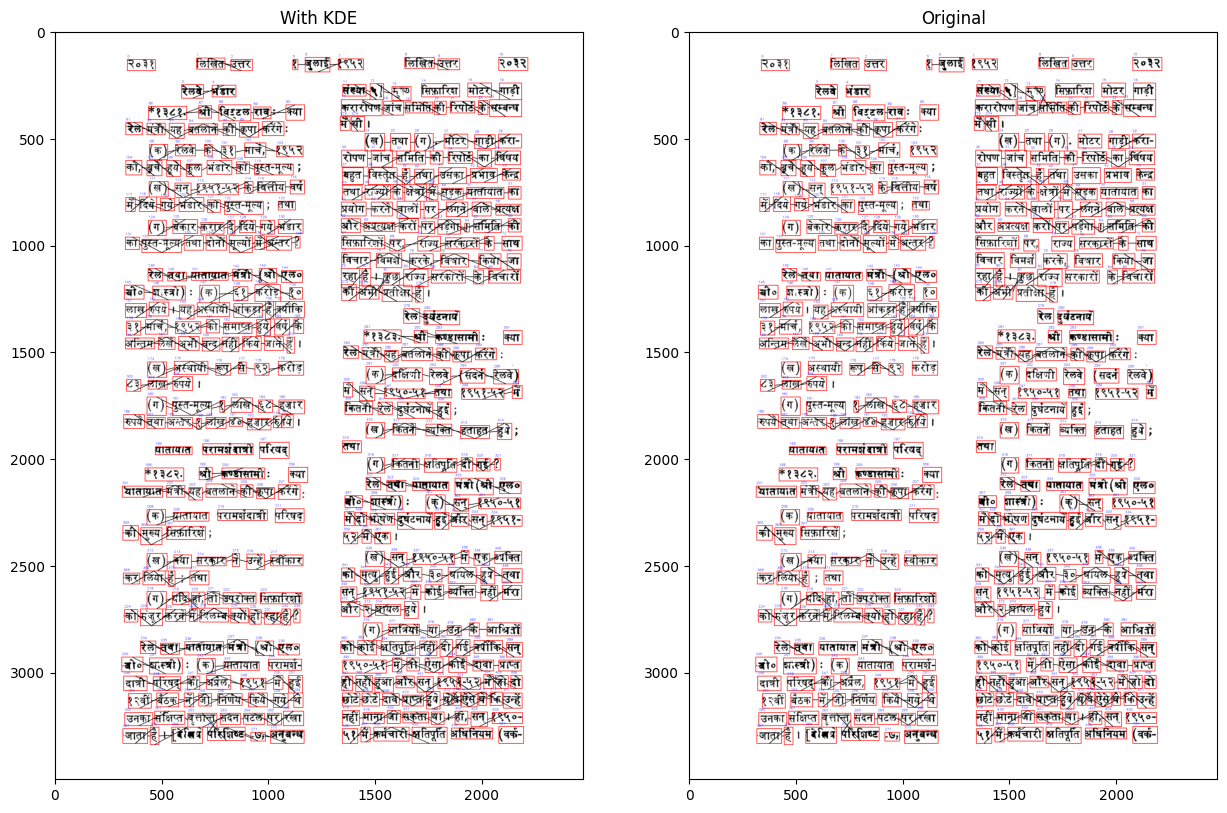

Image:  ./images/101.jpg


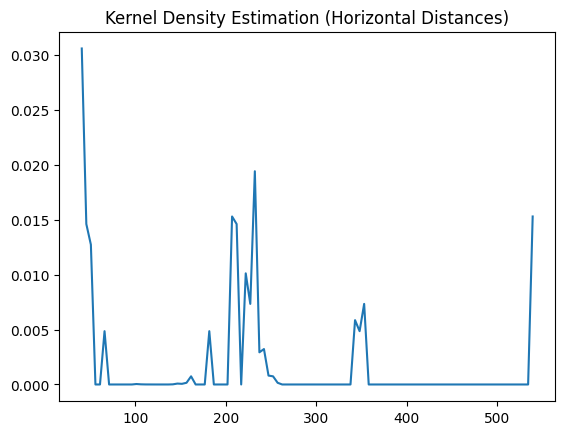

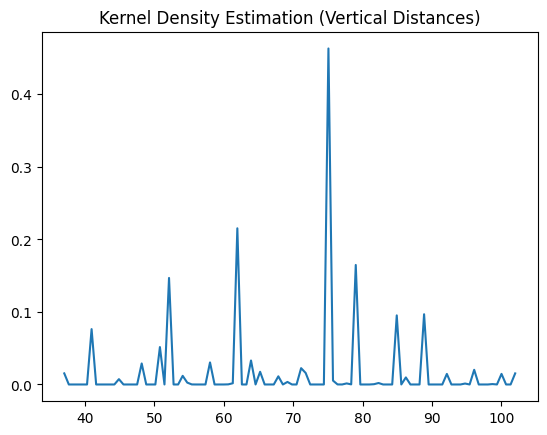

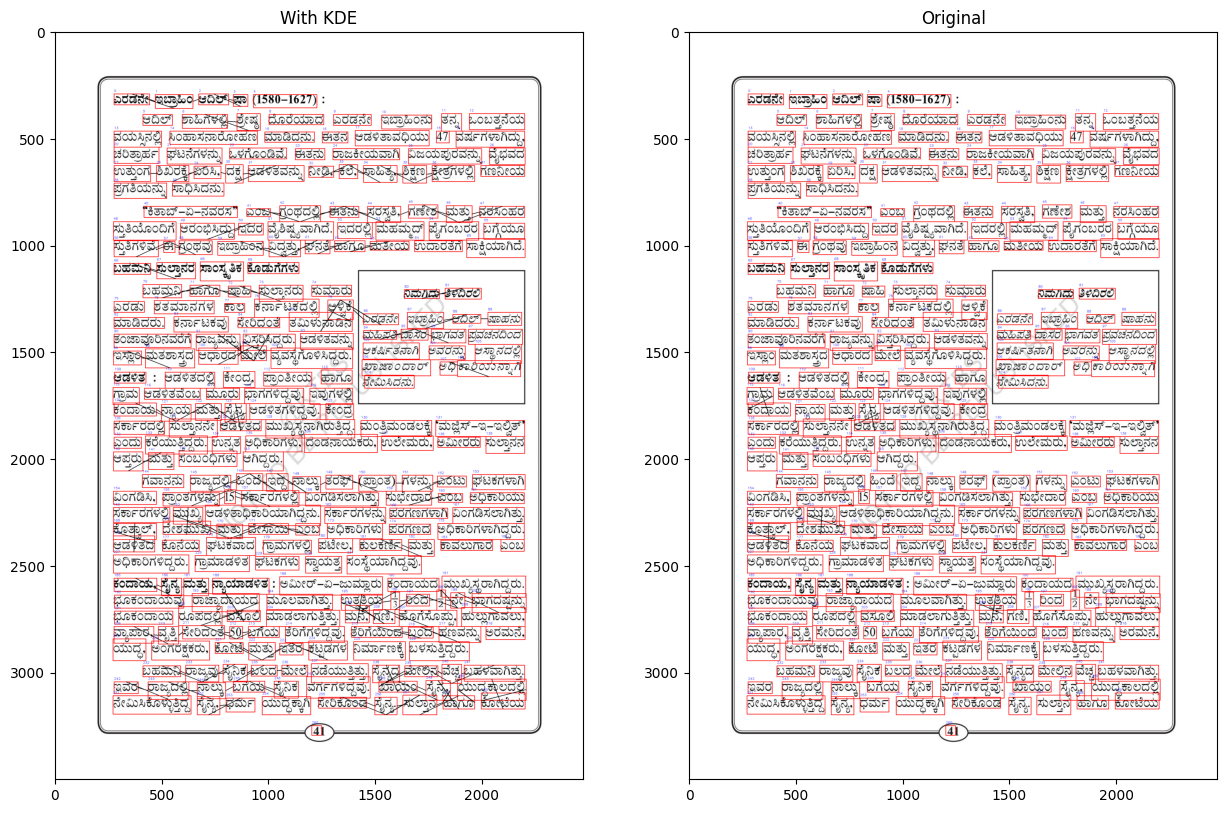

Image:  ./images/159.jpg


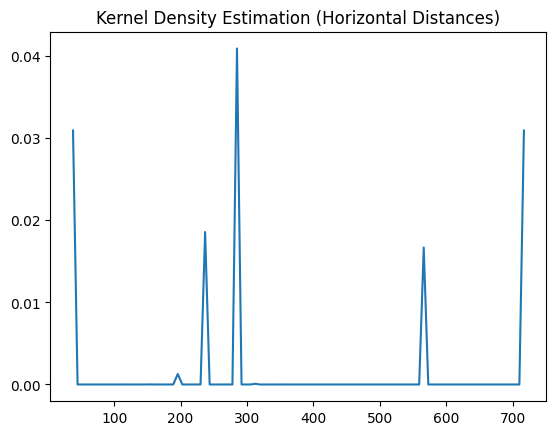

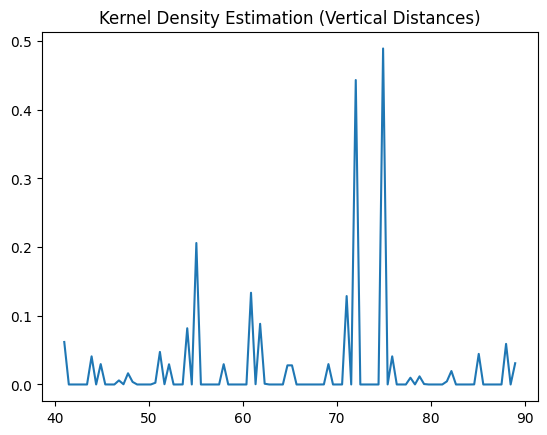

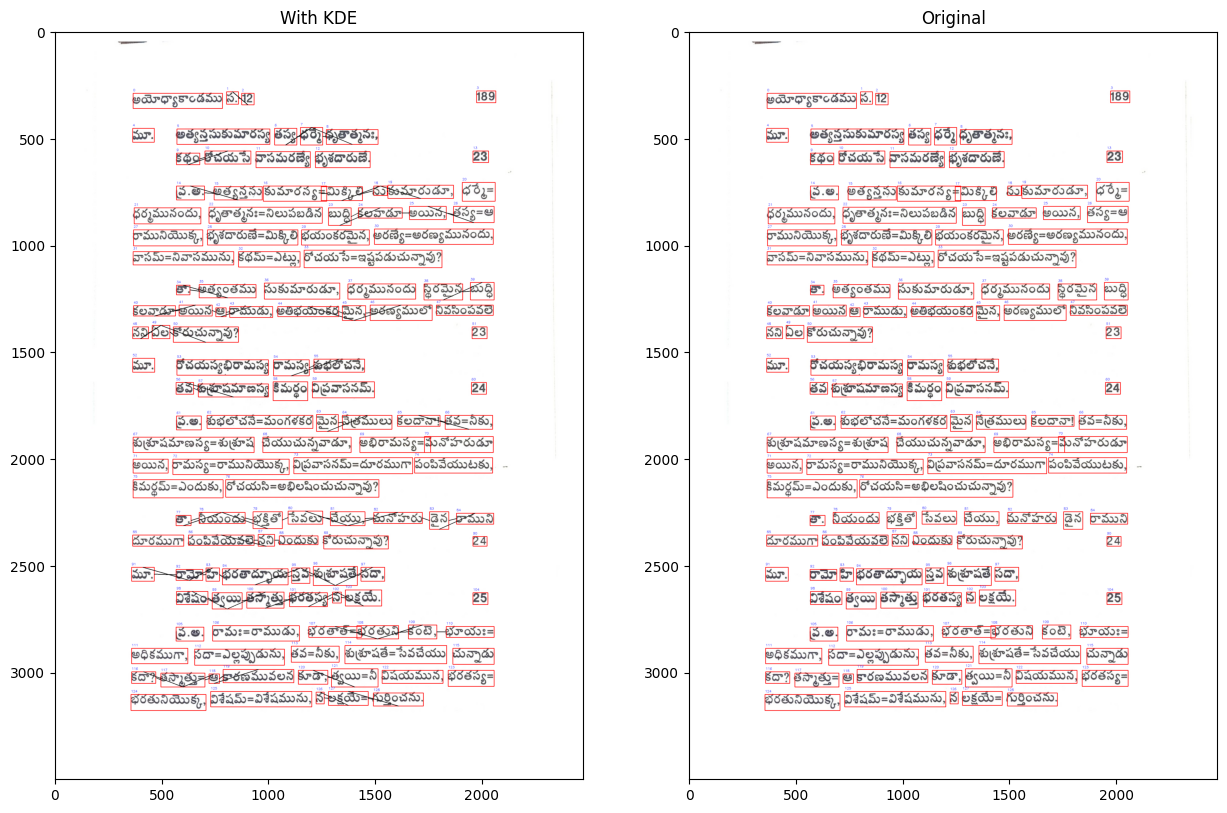

Image:  ./images/174.jpg


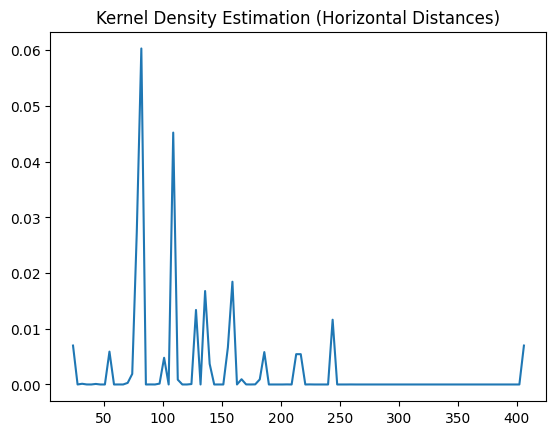

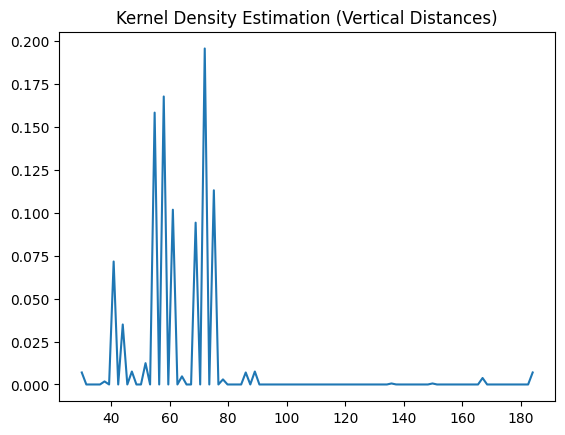

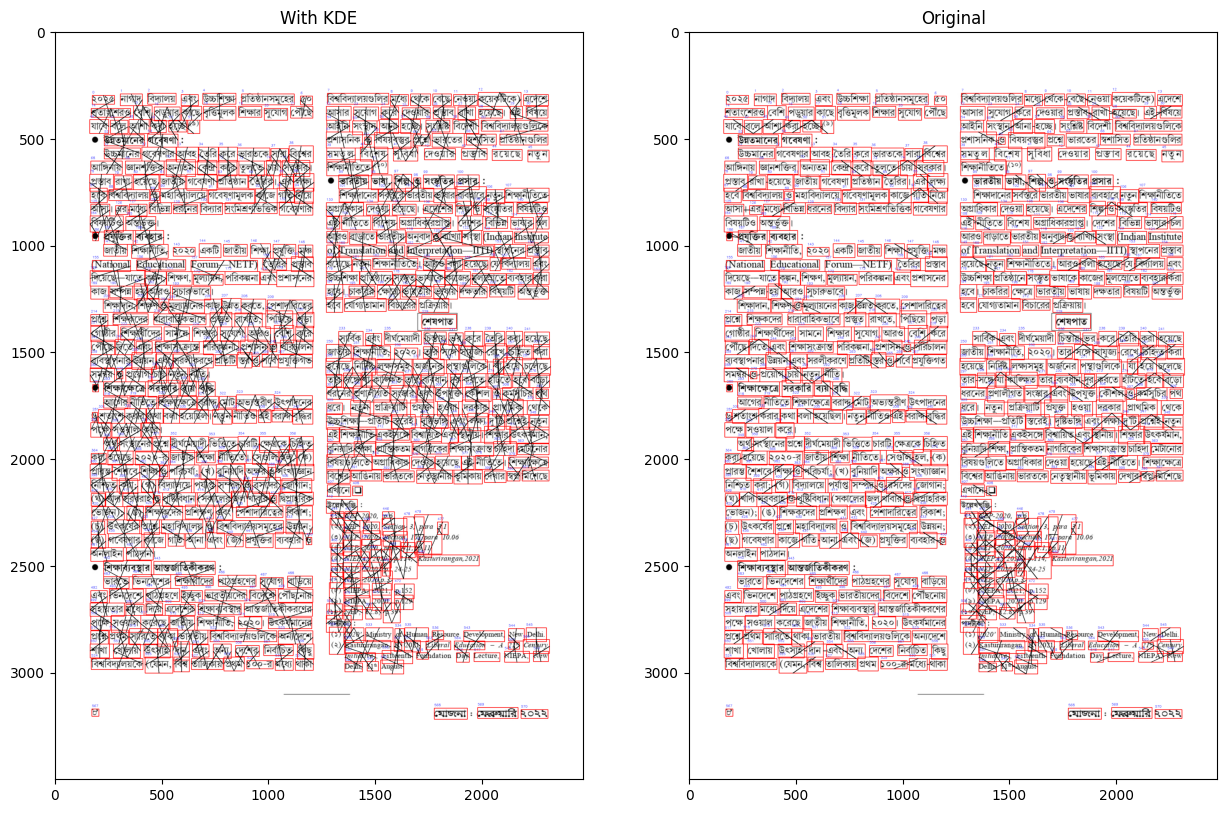

In [187]:
for data, image in zip(data_csv, data_img):
    print("Image: ", image)
    df = pd.read_csv(data)
    img = cv2.imread(image)

    # visualize_bboxes(img, df)

    col = ['CenterX', 'CenterY']
    data = {column: [] for column in col}

    for index, rows in df.iterrows():
        # print(rows)
        top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
        bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
        CenterX = ((top_left[0] + bottom_right[0])/2)
        CenterY = ((top_left[1] + bottom_right[1])/2)
        data['CenterX'].append(CenterX)
        data['CenterY'].append(CenterY)

    centers = pd.DataFrame(data)
    data = make_data(df)

    data['Top_box'] = np.zeros(len(data['Id']))
    data['Bottom_box'] = np.zeros(len(data['Id']))
    data['Left_box'] = np.zeros(len(data['Id']))
    data['Right_box'] = np.zeros(len(data['Id']))
    
    data['Top_box'] = []
    data['Bottom_box'] = []
    data['Left_box'] = []
    data['Right_box'] = []
    
    horizontal_distances = np.sqrt(
        [(right_edge[0] - left_edge[0])**2 for right_edge, left_edge in zip(data['Right'], data['Left'])]
    )

    vertical_distances = np.sqrt(
        [(bottom_edge[1] - top_edge[1])**2 for bottom_edge, top_edge in zip(data['Bottom'], data['Top'])]
    )
    horizontal_distances = horizontal_distances.reshape(-1, 1)
    vertical_distances = vertical_distances.reshape(-1, 1)
    horizontal_distances.shape, vertical_distances.shape

    kde_horizontal = KDE(kernel='gaussian')
    kde_vertical = KDE(kernel='gaussian')

    # Fit and select bandwidths
    kde_horizontal.fit(horizontal_distances)
    kde_vertical.fit(vertical_distances)

    num_points = 100
    x_range_horizontal = np.linspace(np.min(horizontal_distances), np.max(horizontal_distances), num_points)
    pdf_values_horizontal = kde_horizontal.evaluate_density(x_range_horizontal)

    horizontal_threshold = x_range_horizontal[np.argmin(np.abs(np.array(pdf_values_horizontal) - 0.5 * np.max(pdf_values_horizontal)))]
    horizontal_threshold

    num_points = 100
    x_range_vertical = np.linspace(np.min(vertical_distances), np.max(vertical_distances), num_points)
    pdf_values_vertical = kde_vertical.evaluate_density(x_range_vertical)

    # Determine vertical threshold
    vertical_threshold = x_range_vertical[np.argmin(np.abs(np.array(pdf_values_vertical) - 0.5 * np.max(pdf_values_vertical)))]
    vertical_threshold 

    data = calculate_boxes(df, data, vertical_threshold, horizontal_threshold)    
    euclidean = pd.DataFrame(data)

    image_with_connections = make_connections(img, euclidean)

    X = centers['CenterX'].values.reshape(-1,1)
    linkage_matrix = sch.linkage(X, method='single')

    optimal_clusters = 0
    max_silhouette_score = -1
    max_components = 20

    for k in range(2, max_components+1):
        labels = sch.fcluster(linkage_matrix, k, criterion='maxclust')
        silhouette_avg = silhouette_score(X, labels)
        if silhouette_avg > max_silhouette_score:
            max_silhouette_score = silhouette_avg
            optimal_clusters = k

    horizontal_threshold_original = linkage_matrix[-(optimal_clusters - 1), 2]

    Y = centers['CenterY'].values.reshape(-1,1)
    linkage_matrix = sch.linkage(Y, method='single')

    optimal_clusters = 0
    max_silhouette_score = -1
    max_components = 20

    for k in range(2, max_components+1):
        labels = sch.fcluster(linkage_matrix, k, criterion='maxclust')
        silhouette_avg = silhouette_score(Y, labels)
        if silhouette_avg > max_silhouette_score:
            max_silhouette_score = silhouette_avg
            optimal_clusters = k

    vertical_threshold_original = linkage_matrix[-(optimal_clusters - 1), 2]

    data_original = make_data(df)
    data_original = calculate_boxes(df, data_original, vertical_threshold_original, horizontal_threshold_original)    
    euclidean_original = pd.DataFrame(data_original)

    image_with_connections_original = make_connections(img, euclidean_original)

    plt.plot(x_range_horizontal, pdf_values_horizontal, label="Horizontal KDE")
    # plt.plot(horizontal_distances)
    plt.title("Kernel Density Estimation (Horizontal Distances)")
    plt.show()
    
    plt.plot(x_range_vertical, pdf_values_vertical, label="Vertical KDE")
    plt.title("Kernel Density Estimation (Vertical Distances)")
    plt.show()

    plt.figure(figsize=(15, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(image_with_connections)
    plt.title('With KDE')
    plt.subplot(1, 2, 2)
    plt.imshow(image_with_connections_original)
    plt.title('Original')
    plt.show()

    